# 필요한 라이브러리와 데이터 로드

In [3]:
import pandas as pd 
import numpy as np 
import os
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# Pyspark - SQL
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import mean, col, split, regexp_extract, when, lit

# Pyspark - ML
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

# create session
spark = SparkSession.builder\
        .appName('Play with pyspark ML on Titanic Data')\
        .getOrCreate()

# load data
df = spark.read.csv('./data/train.csv', header=True, inferSchema=True)
# toPandas()를 이용해 판다스에서 제공하는 데이터프레임 형태로 출력
df.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S


# Matplotlib, Seaborn을 활용한 간단한 시각화

Matplotlib, Seaborn 을 활용하려면 우선 Spark의 데이터프레임에서 Pandas의 데이터프레임으로 변환해주고 시각화를 구현해야 한다. 따라서 먼저 toPandas() 메소드로 Pandas 형태의 데이터프레임을 새로 할당해주자.

 

pandas_df 타입: <class 'pandas.core.frame.DataFrame'>
/Users/mingggkeee/miniforge3/envs/mingggkeee/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


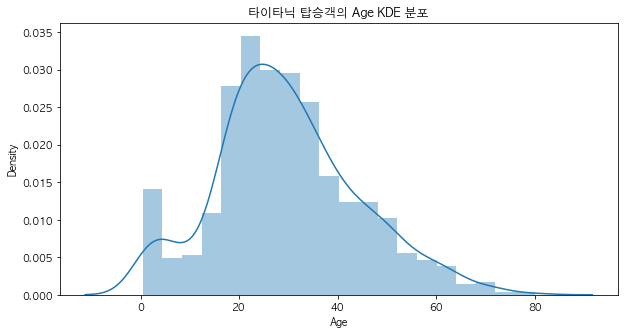

In [5]:
# pandas 데이터프레임 형태로 우선 변환
pandas_df = df.toPandas()
print("pandas_df 타입:", type(pandas_df))

# Seaborn
plt.figure(figsize=(10,5))
plt.title("타이타닉 탑승객의 Age KDE 분포")
sns.distplot(pandas_df['Age'])
plt.show()

# PySpark로 결측치 체크하고 기존변수로부터 파생변수 생성하기

결측치를 체크하는 방법은 크게 2가지가 있다.

 

- isnan() : pyspark.sql.functions 라이브러리에 속한다. 사용방법은 isnan('체크할 column 이름')
- isNull() : pyspark.sql.Column 라이브러리에 속한다. 사용방법은 col('체크할 column 이름').isNull()


In [6]:
from pyspark.sql.functions import isnan, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [7]:
# Cabin 변수는 결측치가 50%가 넘기 때문에 해당 변수를 삭제
df = df.drop('Cabin')

탑승객의 이름을 담고 있는 Initial 칼럼을 이용해 파생변수를 만들어보자. withColumn() 메소드를 사용하면 되는데, 여기서는 PySpark에서 제공하는 정규표현식 API를 함께 이용해보자. 우선 각 메소드에 대한 사용방법을 설명하면 다음과 같다.

- df.withColumn('New column', df['column 1'] + df['column 2'] ) : column 1 값과 column 2 값을 각 더해 New column 이라는 새로운 파생변수 생성
- regexp_extract(col('column 1'), '정규표현식 패턴') : column 1이라는 칼럼 값에서 지정해준 정규표현식 패턴에 해당하는 값들만 추출(extract)해라.(여기서 col('column 1') 을 df['column 1'] 로 표현해도 동일한 표현이다.)
 

여기서는 탑승객들의 이름 중 Mr, Mrs와 같은 성별과 연령 의미를 내포하고 있는 salutation만을 추출하자.(salutation은 우리말로 '인사말'이며 여기서는 사람 이름의 가장 맨 앞에 나오는 Mr, Mrs 같은 것들을 의미한다.)

In [8]:
df = df.withColumn("Initial", regexp_extract(col("Name"),
                                            "([A-za-z]+)\.", # () 이게 하나의 그룹
                                            1)) # 그룹 인덱스는 1부터

df.limit(3).show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Embarked|Initial|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25|       S|     Mr|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|       C|    Mrs|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925|       S|   Miss|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+



In [9]:
df = df.replace(['Mlle','Mme', 'Ms', 'Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                ['Miss','Miss','Miss','Mr','Mr',  'Mrs',  'Mrs',  'Other',  'Other','Other','Mr','Mr','Mr'])

# Initial 변수 값들로 그룹핑한 후 평균 Age 구하기
df.groupby('Initial').avg('Age').collect()

[Row(Initial='Miss', avg(Age)=21.86),
 Row(Initial='Other', avg(Age)=45.888888888888886),
 Row(Initial='Master', avg(Age)=4.574166666666667),
 Row(Initial='Mr', avg(Age)=32.73960880195599),
 Row(Initial='Mrs', avg(Age)=35.981818181818184)]

위 코드에서 collect() 가 등장한다. collect() 도 select() 와 마찬가지로 일부의 데이터를 추출하는 역할을 한다. 하지만 사용목적에 따라 약간의 차이점이 존재한다. collect() 메소드는 다음과 같은 경우에 사용하는 것이 권장된다.

- 적은 양의 데이터셋을 반환할 때 자주 사용. 큰 데이터셋을 로드할 때는 메모리 에러가 발생할 가능성이 높다.
- 보통 filter(), group(), count() 메소드를 사용한 후 같이 자주 사용된다.
- 인자에 아무것도 넣지 않으면 즉, collect() 자체로만 사용한다면 해당 데이터프레임의 모든 row를 반환한다.
- collect() 가 반환하는 타입은 Spark의 데이터프레임 형태가 아닌 PySpark의 Row 타입의 데이터가 담긴 list를 반환한다. list 자료구조이기 때문에 loop 문으로 활용이 가능하다. 
- 또한 PySpark의 Row 타입은 Python의 named Tuple 형태이다.

In [11]:
# 위 코드에서 탑승객 이름의 salutation 별로 Age 평균값을 계산했고 이를 이용해 결측치를 대체해보자.

df = df.withColumn('Age',
                    when((df['Initial'] == 'Miss') & (df['Age'].isNull()),
                    22).otherwise(df['Age']))
df = df.withColumn('Age',
                    when((df['Initial'] == 'Other') & (df['Age'].isNull()),
                    46).otherwise(df['Age']))
df = df.withColumn('Age',
                    when((df['Initial'] == 'Master') & (df['Age'].isNull()),
                    5).otherwise(df['Age']))
df = df.withColumn('Age',
                    when((df['Initial'] == 'Mr') & (df['Age'].isNull()),
                    33).otherwise(df['Age']))
df = df.withColumn('Age',
                    when((df['Initial'] == 'Mrs') & (df['Age'].isNull()),
                    36).otherwise(df['Age']))

In [14]:
# Embarked 변수 결측치 확인
df.groupBy('Embarked').count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    null|    2|
|       C|  168|
|       S|  644|
+--------+-----+



In [15]:
# 최빈값인 S로 대체
df = df.na.fill({"Embarked": "S"})
# 확인
df.groupBy('Embarked').count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|       C|  168|
|       S|  646|
+--------+-----+



# Feature Engineering 하기

In [16]:
# Family size라는 파생변수 생성
df = df.withColumn("Family_Size",
                    col('SibSp')+col('Parch'))

# Alone 이라는 Binary 파생변수 생성, Default 값은 0
df = df.withColumn('Alone', lit(0))
# 조건에 맞게 Alone 값 변경
df = df.withColumn('Alone',
                    when(col('Family_Size') == 0, 1)\
                    .otherwise(col('Alone')))

In [17]:
# 문자열로 되어있는 변수들 숫자로 변환 (Label Encoding)

convert_cols = ['Sex', 'Embarked', 'Initial']

indexer = [StringIndexer(inputCol=col,
                        outputCol=col+'_index').fit(df) for col in convert_cols]

for i in indexer:
    print(i)
    print('-'*80)

print(type(indexer))

StringIndexerModel: uid=StringIndexer_b29f9d90c21b, handleInvalid=error
--------------------------------------------------------------------------------
StringIndexerModel: uid=StringIndexer_3c2366bfc816, handleInvalid=error
--------------------------------------------------------------------------------
StringIndexerModel: uid=StringIndexer_73d3ba00df15, handleInvalid=error
--------------------------------------------------------------------------------
<class 'list'>


In [18]:
#pipeline을 이용해 stage에다가 실행과정 담아 넘기기
pipeline = Pipeline(stages=indexer)
df = pipeline.fit(df).transform(df)

# 불필요한 칼럼들 삭제 후 최종 Feature들을 Vector로 변환하기
PySpark에서 여러개의 칼럼을 삭제하려면 Pandas와는 약간 다른 방법을 사용해야 편리하다. 우선 2가지 방법의 차이점을 알아보자.

- Pandas : df.drop(['columnA', 'columnB', 'columnC'], axis=1)
- PySpark : df.drop('columnA', 'columnB', 'columnC')

In [21]:
un_cols = ["PassengerId", "Name", "Ticket", "Cabin", "Embarked", "Sex", "Initial"]

df = df.drop(*un_cols)  # unpacking 사용
print("삭제 후 남은 컬럼들:", df.columns)

삭제 후 남은 컬럼들: ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family_Size', 'Alone', 'Sex_index', 'Embarked_index', 'Initial_index']


In [22]:
# 벡터 변환

feature = VectorAssembler(inputCols = df.columns[1:],
                        outputCol='features')
feature_vector = feature.transform(df) # 데이터프레임 형태로 변환
print('feature type:', type(feature))
print('feature_vector type', type(feature_vector))

feature_vector.limit(3).toPandas()

feature type: <class 'pyspark.ml.feature.VectorAssembler'>
feature_vector type <class 'pyspark.sql.dataframe.DataFrame'>


,Survived,Pclass,Age,SibSp,Parch,Fare,Family_Size,Alone,Sex_index,Embarked_index,Initial_index,features
0,0,3,22.0,1,0,7.2500,1,0,0.0,0.0,0.0,"(3.0, 22.0, 1.0, 0.0, 7.25, 1.0, 0.0, 0.0, 0.0..."
1,1,1,38.0,1,0,71.2833,1,0,1.0,1.0,2.0,"[1.0, 38.0, 1.0, 0.0, 71.2833, 1.0, 0.0, 1.0, ..."
2,1,3,26.0,0,0,7.9250,0,1,1.0,0.0,1.0,"[3.0, 26.0, 0.0, 0.0, 7.925, 0.0, 1.0, 1.0, 0...."


# Train, Test 데이터 분할

In [23]:
titanic_df = feature_vector.select(['features', 'Survived'])

# split train, test
(train_df, test_df) = titanic_df.randomSplit([0.8, 0.2], seed=42)

# 머신러닝 분류 모델 만들기

이진 분류 모델을 만들어보자 PySpark에서는 ParamGridBuilder() 를 통해 하이퍼파라미터 튜닝을 수행하면서 TrainValidationSplit() 메소드로 교차검증을 동시해 수행할 수 있다.

In [25]:
# 분류 모델
from pyspark.ml.classification import LogisticRegression
# 파라미터 튜닝 & 교차 검증
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.tuning import CrossValidator
# 파이프라인
from pyspark.ml import Pipeline
# 메트릭 얻는 라이브러리
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# ROC AUC(sklearn)
from sklearn.metrics import roc_curve, auc

# 모델 정의
lr = LogisticRegression(labelCol='Survived')

# 튜닝할 파라미터 grid 정의
# model.parameter 식으로 정의

paramGrid = ParamGridBuilder().addGrid(lr.regParam,
                                    (0.01, 0.1))\
                              .addGrid(lr.maxIter,
                                    (5, 10))\
                              .addGrid(lr.tol,
                                    (1e-4, 1e-5))\
                              .addGrid(lr.elasticNetParam,
                                    (0.25, 0.75))\
                              .build()

# 교차검증 정의 - Pipeline식으로 정의
tvs = TrainValidationSplit(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol='Survived'),
                          trainRatio=0.8)

# 학습은 fit
model = tvs.fit(train_df)
# 평가는 transform
model_prediction = model.transform(test_df)

# 메트릭 평가
print('Accuracy:',
      MulticlassClassificationEvaluator(labelCol='Survived',
                                        metricName='accuracy').evaluate(model_prediction))

print('Precision:',
      MulticlassClassificationEvaluator(labelCol='Survived',
                                        metricName='weightedPrecision').evaluate(model_prediction))

Accuracy: 0.7586206896551724
Precision: 0.761755485893417


In [26]:
model_prediction.show(10)

+--------------------+--------+--------------------+--------------------+----------+
|            features|Survived|       rawPrediction|         probability|prediction|
+--------------------+--------+--------------------+--------------------+----------+
|(10,[0,1,2,4,5],[...|       0|[0.72006539580057...|[0.67262141750634...|       0.0|
|(10,[0,1,2,4,5],[...|       0|[0.75785957027803...|[0.68088884304856...|       0.0|
|(10,[0,1,2,4,5],[...|       0|[0.76172891792904...|[0.68172898283271...|       0.0|
|(10,[0,1,2,4,5],[...|       0|[0.75268356963787...|[0.67976315418566...|       0.0|
|(10,[0,1,2,4,5],[...|       0|[1.24690393739705...|[0.77676345782325...|       0.0|
|(10,[0,1,2,4,5],[...|       0|[1.24781216579257...|[0.77692090684506...|       0.0|
|(10,[0,1,2,4,5],[...|       0|[1.68635194799240...|[0.84374380287544...|       0.0|
|(10,[0,1,2,4,5],[...|       0|[1.68586477273490...|[0.84367956283645...|       0.0|
|(10,[0,1,2,4,5],[...|       0|[1.66490764925688...|[0.8408956970

- featrues : (10, [0,1,2,4,5], ... ) : 10개의 feature가 존재하고 각 feature의 값들은 0,1,2,4,5 이다. 
- rawPrediction : 해당 feature를 회귀 모델에 넣었을 때 계산되어 나오는 Raw한 결과값
- probability : rawPrediction 값에 로지스틱 함수를 적용한 후 변한된 값. 즉 0과 1사이의 확률값으로 매핑된 값
- prediction : probability가 특정 임계값 기준에 의해 1 또는 0으로 분류된 클래스(label)

# ROC Curve 시각화하고 AUC Score 계산하기
이제 위 테이블에서 probability 와 Survived 칼럼들만 뽑아서 AUC 계산에 필요한 label 값과 Positive(1)로 예측될 확률값만을 뽑아보자.

In [27]:
# Evaluate ROC metric
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric 
from pyspark import SparkContext

sc = SparkContext.getOrCreate()

# ROC 점수인 AUC를 계산 위해 Logistic를 적용해 나온 확률값과 레이블만 가져오기
results = model_prediction.select(['probability', 'Survived'])

# 확률값 - 레이블 set 준비
# collect()를 모든 데이터 row retrieve(반환) - 리스트 형태로 반환
results_collect = results.collect()

# named tuple 형식이기 때문에 key 값으로 원하는 값을 불러올 수 있다
print(results_collect[0])
print()
print('probability:', results_collect[0].probability)
print('Survived:', results_collect[0].Survived)

Row(probability=DenseVector([0.6726, 0.3274]), Survived=0)

probability: [0.6726214175063402,0.3273785824936598]
Survived: 0


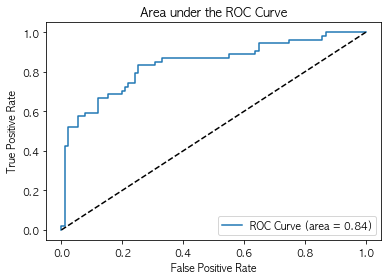

In [28]:
# Evaluate ROC metric
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark import SparkContext

# SparkContext를 만들기
sc = SparkContext.getOrCreate()

# ROC 점수인 AUC를 계산 위해 Logistic를 적용해 나온 확률값과 레이블만 가져오기
results = model_prediction.select(['probability', 'Survived'])

# 확률값 - 레이블 set 준비시키기
# collect()로 모든 데이터 row retrieve(반환) - 리스트 형태로 반환
results_collect = results.collect()
results_list = [(float(i.probability[1]),
                 float(i.Survived)) for i in results_collect]
# 여러개의 튜플이 담긴 list를 RDD 자료구조로 변경
scoreAndLabels = sc.parallelize(results_list)
# ROC metric 계산하기
metrics = metric(scoreAndLabels)
auc = metrics.areaUnderROC

# Visualize ROC Curve
from sklearn.metrics import roc_curve, auc

# roc_curve 는 실제값, 1로의 예측확률값을 인자로 넣어주면 FPR, TPR, 임곗값을 반환해줌
fpr = []
tpr = []
roc_auc = []

y_test = [i[1] for i in results_list]
y_proba = [i[0] for i in results_list]

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
# x축엔 Fall-out(FPR), y축엔 Recall(TPR)
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Area under the ROC Curve")
plt.legend(loc='lower right')
plt.show()